In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("p2-arbres-fr.csv", sep=";")
data.info()
data.describe()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  132932 non-null  object 
 15  remarquable      

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200132,2024741,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170151,NaN,Castanea,fargesii,NaN,0,0,NaN,0.0,48.821957,2.456264
200133,2024742,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170152,Arbre aux mouchoirs,Davidia,involucrata,NaN,0,0,NaN,0.0,48.823254,2.457935
200134,2024743,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170153,Peuplier,Populus,simonii,NaN,0,0,NaN,0.0,48.822907,2.457970
200135,2024744,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170154,Chêne,Quercus,n. sp.,NaN,0,0,NaN,0.0,48.822522,2.455956


In [4]:
data.drop(["complement_addresse", "numero", "variete", "remarquable", "libelle_francais", "type_emplacement", "domanialite"], axis="columns", inplace=True)
data.head()

,id,arrondissement,lieu,id_emplacement,genre,espece,circonference_cm,hauteur_m,stade_developpement,geo_point_2d_a,geo_point_2d_b
0,99874,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Aesculus,hippocastanum,20,5,NaN,48.857620,2.320962
1,99875,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,Taxus,baccata,65,8,A,48.857656,2.321031
2,99876,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,Taxus,baccata,90,10,A,48.857705,2.321061
3,99877,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Acer,negundo,60,8,A,48.857722,2.321006
4,99878,PARIS 17E ARRDT,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Tetradium,daniellii,38,0,NaN,48.890435,2.315289


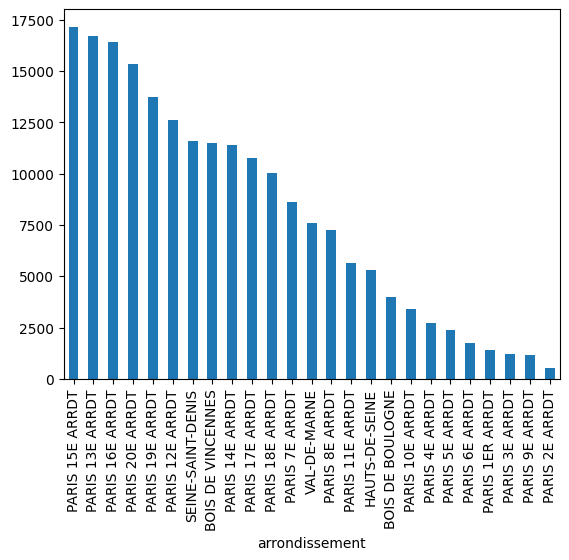

In [5]:
data["arrondissement"].value_counts().plot(kind="bar")
plt.show()

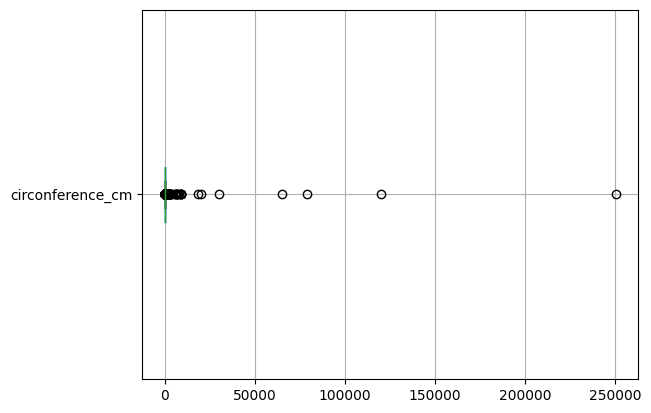

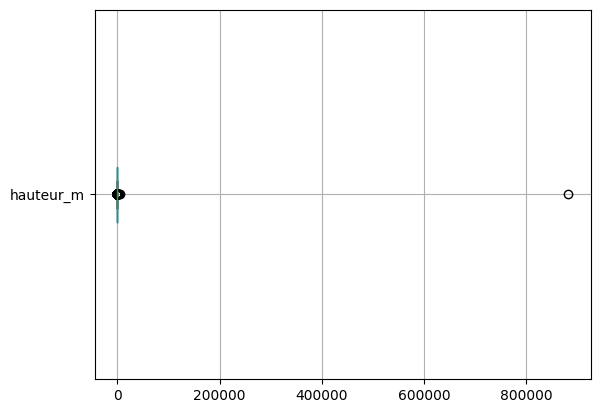

In [6]:
data.boxplot(column="circonference_cm", vert=False)
plt.show()
data.boxplot(column="hauteur_m", vert=False)
plt.show()

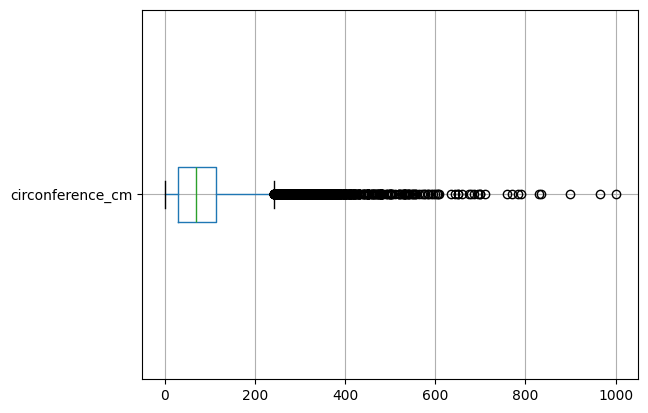

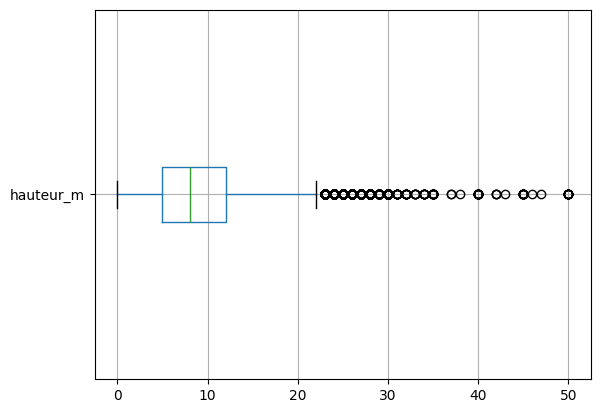

La circonference moyenne d'un arbre est de 79.73cm
La hauteur moyenne d'un arbre est de 8.33m


In [7]:
data[data["hauteur_m"] > 50] = np.nan
data[data["circonference_cm"] > 1000] = np.nan
data.boxplot(column="circonference_cm", vert=False)
plt.show()
data.boxplot(column="hauteur_m", vert=False)
plt.show()
print("La circonference moyenne d'un arbre est de {}cm".format(data["circonference_cm"].mean().round(2)))
print("La hauteur moyenne d'un arbre est de {}m".format(data["hauteur_m"].mean().round(2)))

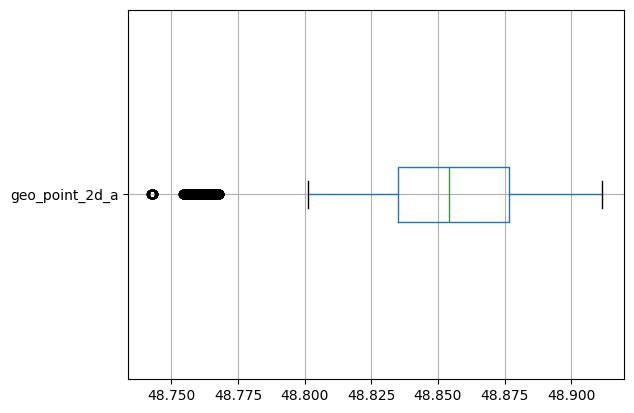

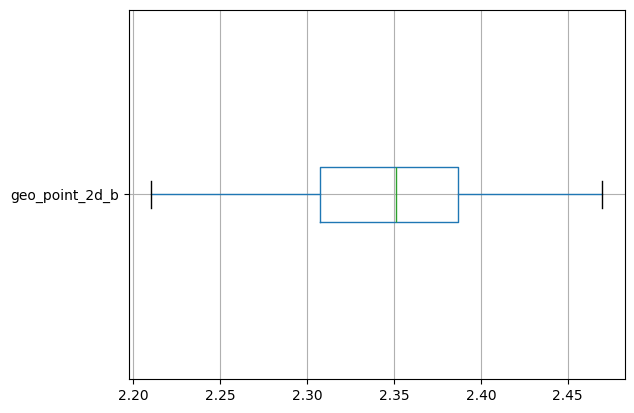

In [8]:
data.boxplot(column="geo_point_2d_a", vert=False)
plt.show()
data.boxplot(column="geo_point_2d_b", vert=False)
plt.show()